# Random Tree Classifier on bbox coordinates/cropped images

##### Importing required libraries

In [1]:
from torch.utils.data import DataLoader
from src.utils import collate_fn
from src.dataset import CropsScikitDataset
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import pandas as pd
import numpy as np
import cv2

##### Preprocessing Data

In [ ]:
# Function to preprocess data
def preprocess(data: list, mode: str = 'crop'):
    """
    Function to preprocess data to match the Random Forest Classifier from scikit-learn.
    The fitting function expects:
    
    * X: Training input samples, {array-like} of shape (n_samples, n_features), where n-dim <= 2
    * y: Target values, array-like of shape (n_samples) or (n_samples, n_outputs), where n-dim <= 2
    * sample_weight: If None, samples are equally weighted.
    
    Parameters:
    -----------
    - data: list\n
    A list containing the features and labels of the data. 
     
    - mode: str, `default = "crop" | "crop", "bbox"`\n
      Used to specify whether we are preprocessing bounding box coordinates, images or image crops. By default `<mode>` is set to preprocess bounding box coordines.
    """
    
    # Reshaping labels to 1D-array because classifier expect dim <= 2
    #print("before flattening:",data[1])
    #print("before flatten",data[1])
    labels = np.array(data[1]).ravel()#.flatten()
    
    #labels = np.array(data[1])
    #labels = np.vstack(labels).ravel()
    #labels = data[1].numpy()
    #print("reshaped labels:",labels)
    
    if mode == "crop":
      # Convert tensors to numpy, then find the maximum height and width among all crops
      features = [image.numpy() for image in data[0]]
      max_height = max(img.shape[0] for img in features)
      max_width = max(img.shape[1] for img in features)
      #print(f"max_height, max_width: ({max_height},{max_width})")

      # Add centered padding around the crop to match max height and width
      # To counter floor divison we add +1
      features = [np.pad(img,pad_width=(((max_height - img.shape[0])//2, (max_height - img.shape[0] + 1)//2),
                                      ((max_width - img.shape[1])//2, (max_width - img.shape[1] + 1)//2)),
                                        mode="constant", constant_values=0.0) for img in features]
     
      # Reshaping features from 3D to 2D
      features = np.array(features)
      samples,nx,ny = features.shape
      features = features.reshape(samples,nx*ny)
      return features, labels
      
    elif mode == "bbox":
      features = [coord for coord in data[0]]
      features = np.array(features)
      #print(features)
      return features, labels
      
    #return features, labels, [org3d, org2d, reshaped]
    #return features, labels

##### Setting up custom dataset and dataloader

In [2]:
# Setting up custom dataset and dataloader
le = LabelEncoder()
le.fit(['human-ride-bicycle', 'human-walk-bicycle', 'human-hold-bicycle', 'human-ride-motorcycle', 'human-walk-motorcycle'])


train_dataset = CropsScikitDataset(anno_file=r'annotations_hoi_frame_741.csv', img_dir = r'../images', label_encoder=le)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

test_dataset = CropsScikitDataset(anno_file=r'annotations_hoi_frame_741.csv', img_dir = r'../images', label_encoder=le)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Get all class labels to calculate weight
list1 = []
for data,labels,_ in train_dataloader:
    features, label = preprocess((_,labels),mode="bbox")
    list1.append(label)
#print(list1)
list1 = np.concatenate(list1)
class_weights = compute_class_weight(class_weight="balanced",classes=np.unique(list1),y=list1)
print(class_weights)

print("Class Weights:", dict(zip(np.unique(list1), class_weights)))


##### Training loop

In [ ]:
# Training loop
epochs = 20
seed = 42
rf_classifier = RandomForestClassifier(n_estimators=1,random_state=seed, warm_start=True)

#img, label, coord = next(iter(test_dataloader))
#print(coord)
#features, labels = preprocess((coord, label), mode="bbox")
#rf_classifier.fit(features,labels)

for epoch in (range(epochs)):
    print(f"\nINFO: EPOCH {epoch+1}/{epochs}")
    #img, label, coord = next(iter(test_dataloader))
    #features, labels = preprocess((coord, label), mode="bbox")
    ##print(features, labels.shape)
    #rf_classifier.fit(features,labels)
    #rf_classifier.n_estimators += 1 # Adding another tree
    
    
    for frames, labels, coords in tqdm(train_dataloader,total=(len(train_dataloader)),leave=True):
        #features, labels = preprocess((frames, labels), mode="crop")
        #print(labels)
        features, labels = preprocess((coords, labels), mode="bbox")
        #print(labels)
        rf_classifier.fit(features,labels)
        rf_classifier.n_estimators += 1 # Adding another tree

In [ ]:
# Testing stuff
print(rf_classifier.estimators_)
test, _ = preprocess(([[100, 100, 50, 50],[100, 100, 50, 50]],labels), mode="bbox")
print(test)
#print(test.shape)
#print(test.reshape(1,-1))
#print(test.reshape(2,4))
print(rf_classifier.predict(test))

##### Testing classifier on our data

In [ ]:
# Testing classifier on a new testset
predictions = []
labels = []
for batch in tqdm(test_dataloader, total=len(test_dataloader)):
    frames, targets, coords = batch
    
    # Preprocess data
    features, label = preprocess((coords,targets), mode="bbox")
    labels.append(label)
    
    #print(features)
    #print(coords)
    # Make predictions on the new test set
    predictions.append(rf_classifier.predict(features))

# Evaluate the classifier
accuracy = accuracy_score(labels, predictions)
#print(f"Accuracy: {accuracy}")
#print(classification_report(labels, predictions))
# Compute accuracy by confusion matrix
cm_matrix = confusion_matrix(labels, predictions)
# Plot confusion matrix
cm_matrix = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=rf_classifier.classes_)
#cm_matrix.plot()
for pred, truth in zip(predictions, labels):
    if pred != truth:
        print(f"Incorrect Prediction: {le.inverse_transform([pred])}, Actual: {le.inverse_transform([truth])}")


##### ***INEFFICIENT!*** Load all data into memory

In [3]:
data_list_bbox = []
data_list_crop = []
org_imgs = []
for batch in train_dataloader:
    crop, label, coord, _ = batch
    data_list_bbox.append((coord,label))
    #data_list_bbox.append((crop,label))
    
for batch in test_dataloader:
    crop, label, coord, org = batch
    data_list_crop.append((crop,label))
    org_imgs.append(org)

##### Old preprocessing of data

In [4]:
def preprocess(data, frame):
    # Separate features and labels in separate lists
    # Reshaping labels cause classifier expect dim <= 2
    # We unpack data_list2
    features, labels = zip(*data)
    labels = np.array(labels).reshape(-1)

    # Converts each img tensor to numpy arrays
    features = [image[0].numpy() for image in features]
    org3d = features[frame]
    print("Original 3D image",features[frame].shape)
    #print(features[0])
    #plt.figure(1)
    #plt.title("3d img")
    #plt.imshow(features[10])

    # We reshape the img from a 3D to 2D array
    features = [image.reshape(image.shape[0],-1) for image in features]
    print("Reshaped 2D image",features[frame].shape)
    #print(features[0])
    #print(features[10])
    org2d = features[frame]
    #plt.figure(2)
    #plt.title("2d img")
    #plt.imshow(features[10], cmap='gray', aspect='auto')


    # Find the maximum height and width among all crops
    max_height = max(img.shape[0] for img in features)
    max_width = max(img.shape[1] for img in features)
    #print(f"({max_height},{max_width})")

    # Add centered padding around the crop to match max height and width
    # To counter floor divison we add +1
    features = [np.pad(img,pad_width=(((max_height - img.shape[0])//2, (max_height - img.shape[0] + 1)//2),
                                    ((max_width - img.shape[1])//2, (max_width - img.shape[1] + 1)//2)),
                    mode="constant", constant_values=0.0) for img in features]
    print("Center-Padded 2D image",features[frame].shape)
    #print(features[0])
    reshaped = features[frame].reshape(max_height,max_width)
    #plt.figure(3)
    #plt.title("padded 2d img")
    #plt.imshow(features[0].reshape(max_height,max_width), cmap='gray', aspect='auto')

    # Also need to reshape the entire features list to np array
    features = np.array(features)
    samples,nx,ny = features.shape
    features = features.reshape(samples,nx*ny)
    
    return features, labels, [org3d, org2d, reshaped]

##### Training clf on bbox coordinates

In [ ]:
# Training classifier on bbox coordinates
# Separate features and labels in separate lists
# Reshaping labels cause classifier expect dim <= 2
features, labels = zip(*data_list_bbox)
labels = np.array(labels).reshape(-1)
features = np.array([coord[0] for coord in features])
print(labels.shape)
#print(features)
print(features.shape)
#features = [image[0].reshape(-1).numpy() for image in features]

# Split the data into training and testing sets with random seed
seed = 1
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=seed)

# Creating a RandomForestClassifier with 100 trees with random seed
# Trying to fit the features (cropped frames of human+object)
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=seed)
rf_classifier.fit(X_train,y_train)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))


# Compute accuracy by confusion matrix
cm_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
cm_matrix = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=rf_classifier.classes_)
cm_matrix.plot()

for pred, truth in zip(predictions, y_test):
    if pred != truth:
        print(f"Incorrect Prediction: {le.inverse_transform([pred])}, Actual: {le.inverse_transform([truth])}")

"""
### Observation ###
Due to different shapes of the cropped frames
i cant train the classifier on the features.

I might try padding the crops?

Trying to pass coordinates instead, works.
"""

##### Training clf on cropped imgs

Original 3D image (18, 62)
Reshaped 2D image (18, 62)
Center-Padded 2D image (77, 62)
Accuracy: 0.3945885005636979
              precision    recall  f1-score   support

           0       0.31      0.96      0.47        23
           1       0.97      0.31      0.47       663
           2       0.18      0.53      0.27        80
           3       0.17      0.58      0.26        90
           4       0.42      0.87      0.56        31

    accuracy                           0.39       887
   macro avg       0.41      0.65      0.41       887
weighted avg       0.78      0.39      0.44       887



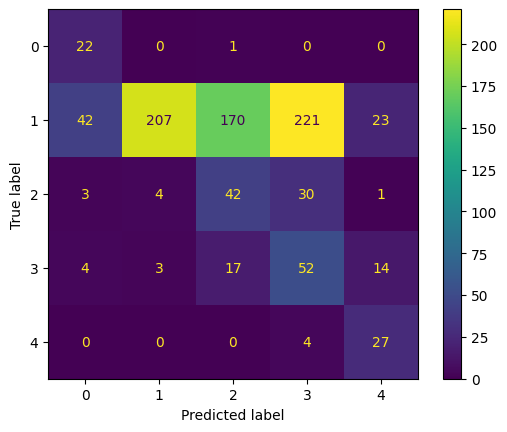

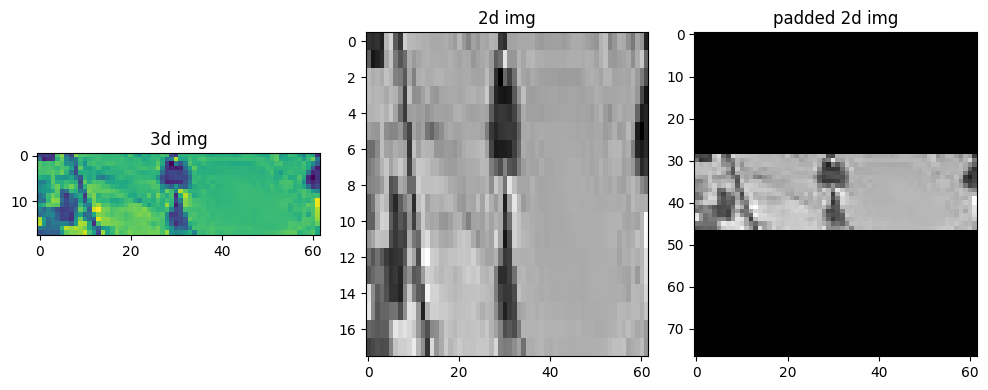

In [5]:
# Training classifier on cropped imgs
features, labels, plots = preprocess(data_list_crop, 10)

# Split the data into training and testing sets with random seed
seed = 0
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.8, random_state=seed)

# Creating a RandomForestClassifier with 10 trees with random seed
# Trying to fit the features (cropped frames of human+object)
#rf_classifier = RandomForestClassifier(n_estimators=10, random_state=seed)
rf_classifier = BalancedRandomForestClassifier(n_estimators=500, random_state=0, sampling_strategy="all", replacement=True,max_depth=5)
rf_classifier.fit(X_train,y_train)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))


# Compute accuracy by confusion matrix
cm_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
cm_matrix = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=rf_classifier.classes_)
cm_matrix.plot()

#for pred, truth in zip(predictions, y_test):
#    if pred != truth:
#        print(f"Incorrect Prediction: {le.inverse_transform([pred])}, Actual: {le.inverse_transform([truth])}")

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("3d img")
plt.imshow(plots[0])

plt.subplot(1,3,2)
plt.title("2d img")
plt.imshow(plots[1], cmap='gray', aspect='auto')

plt.subplot(1,3,3)
plt.title("padded 2d img")
plt.imshow(plots[2], cmap='gray', aspect='auto')
plt.tight_layout()

##### Test on our own data

Original 3D image (38, 19)
Reshaped 2D image (38, 19)
Center-Padded 2D image (77, 62)
Accuracy: 0.4214801444043321
              precision    recall  f1-score   support

           0       0.30      0.96      0.46        28
           1       0.98      0.33      0.50       835
           2       0.20      0.59      0.30        95
           3       0.19      0.65      0.30       110
           4       0.43      0.90      0.59        40

    accuracy                           0.42      1108
   macro avg       0.42      0.69      0.43      1108
weighted avg       0.79      0.42      0.46      1108

Incorrect Prediction: ['human-ride-motorcycle'], Actual: ['human-ride-bicycle']
Incorrect Prediction: ['human-walk-bicycle'], Actual: ['human-ride-bicycle']
Incorrect Prediction: ['human-ride-motorcycle'], Actual: ['human-ride-bicycle']
Incorrect Prediction: ['human-walk-bicycle'], Actual: ['human-ride-bicycle']
Incorrect Prediction: ['human-walk-bicycle'], Actual: ['human-ride-bicycle']
Incor

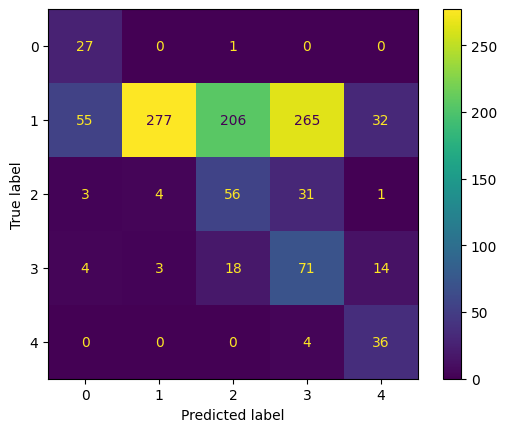

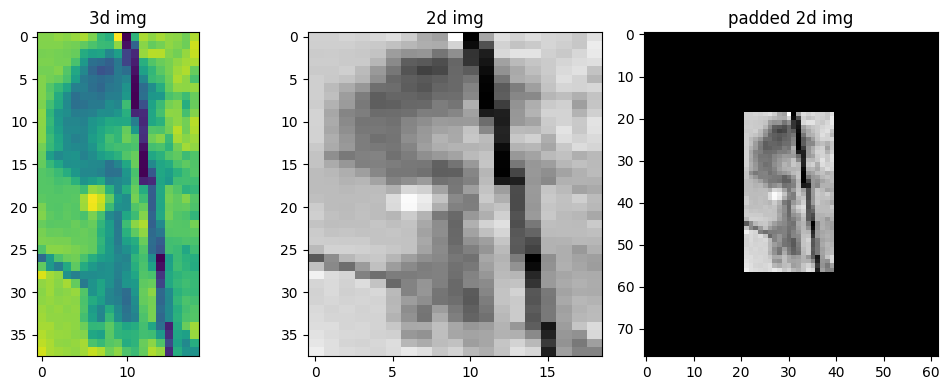

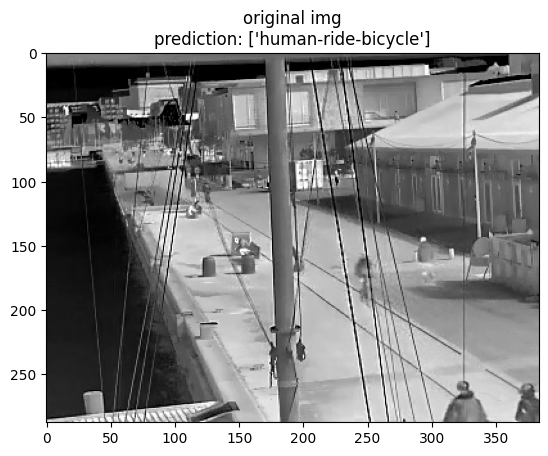

In [6]:
# Preprocess data
frame = int(input("frame no: "))
features, labels, plots = preprocess(data_list_crop, frame)

# Make predictions on the new test set
predictions = rf_classifier.predict(features)

# Evaluate the classifier
accuracy = accuracy_score(labels, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(labels, predictions))


# Compute accuracy by confusion matrix
cm_matrix = confusion_matrix(labels, predictions)

# Plot confusion matrix
cm_matrix = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=rf_classifier.classes_)
cm_matrix.plot()
for pred, truth in zip(predictions, labels):
    if pred != truth:
        print(f"Incorrect Prediction: {le.inverse_transform([pred])}, Actual: {le.inverse_transform([truth])}")

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("3d img")
plt.imshow(plots[0])

plt.subplot(1,3,2)
plt.title("2d img")
plt.imshow(plots[1], cmap='gray', aspect='auto')

plt.subplot(1,3,3)
plt.title("padded 2d img")
plt.imshow(plots[2], cmap='gray', aspect='auto')
plt.tight_layout()

plt.figure()
plt.title(f"original img\nprediction: {le.inverse_transform([labels[frame]])}")
plt.imshow(org_imgs[frame][0])